## By Thomas Torku based on yfinance from Jean Cruz

In [111]:
import keras
import tensorflow as tf
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =6,6
from datetime import datetime

## Grab Data

In [112]:
def getstock(name):
    t = yf.Ticker(name)
    dat = t.history(start='1985-01-01', end='2018-08-01')
    return np.array(dat['Close'])[-3500:]
# np.array(dat['Open'][-5900:])

In [113]:
yf.Ticker('AAPL').history(period='max')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.41,0.41,0.41,0.41,117258400,0.0,0.0
1980-12-15,0.39,0.39,0.39,0.39,43971200,0.0,0.0
1980-12-16,0.36,0.36,0.36,0.36,26432000,0.0,0.0
1980-12-17,0.37,0.37,0.37,0.37,21610400,0.0,0.0
1980-12-18,0.38,0.38,0.38,0.38,18362400,0.0,0.0
...,...,...,...,...,...,...,...
2020-04-22,273.61,277.90,272.20,276.10,29264300,0.0,0.0
2020-04-23,275.87,281.75,274.87,275.03,31203600,0.0,0.0
2020-04-24,277.20,283.01,277.00,282.97,31627200,0.0,0.0


## Visualize the Close Prices of the 4 Stocks

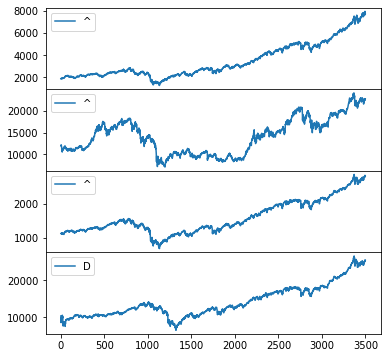

In [114]:
stocks = [ '^IXIC','^N225', '^GSPC', 'DJI'] #Grab 4 stocks
dat = np.array([getstock(n) for n in stocks])
#Graph them
fig, ax=plt.subplots(4,1)
fig.subplots_adjust(hspace=0)
for i in range(len(stocks)):
    ax[i].plot(dat[i])
    ax[i].legend(str(stocks[i]), loc='best')

## Normalize the data

In [115]:
def norm(data, window_width, timesteps):
    """
    window_width: length of data for moving forward in time
    timestps for predicting future prices
    """
    x = np.array([dat[:,i:i+window_width]/dat[:,i, None]  for i in range(dat.shape[1] - window_width - 1)])
    xx = np.array([dat[:,i:i+window_width] for i in range(dat.shape[1] - window_width - 1)])
    y = np.array([dat[:,i+window_width]/dat[:,i]  for i in range(dat.shape[1] - window_width - 1)])
    yy = np.array([dat[:,i+window_width]  for i in range(dat.shape[1] - window_width - 1)])
    return x,xx, y,yy
x,xx, y, yy =norm(dat, 200, 1)

In [116]:
yy.shape

(3299, 4)

## The Feed-Forward or Deep (DNN Model)

In [117]:
from keras.models import Sequential
model = Sequential()
model.add(keras.layers.Dense(4096, activation='relu', input_shape=[x.shape[1], x.shape[2]]))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(y.shape[1], activation='linear'))
model.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.Nadam(learning_rate=0.001),
             metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4, 4096)           823296    
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 65540     
Total params: 888,836
Trainable params: 888,836
Non-trainable params: 0
_________________________________________________________________


In [179]:
history = model.fit(x, y, batch_size=64, epochs=60, verbose=0, validation_split=0.3)

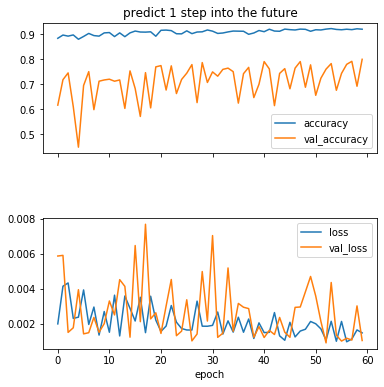

In [180]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(hspace=0.5)
ax1.title.set_text(f'predict 1 step into the future')

ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.legend()

ax2.set_xlabel('epoch')
print()

In [181]:
score= model.evaluate(x, y, verbose=0)
print('Training Loss', score[0])
print('Training  Accuracy', score[1])

Training Loss 0.0008245347148373429
Training  Accuracy 0.886329174041748


## RMSE for each 4 Stocks

In [182]:
### RMSE for each four Stocks
inp = x[-990:]
inpx = xx[-990:]
inpy = yy[-990:]
p = model.predict(inp)
exp = y[-990:]*inpy
pred=p*inpy
#ixic
e1 =exp[:,0:1]
pr1=pred[:,0:1]
#n225
e2 =exp[:,1:2]
pr2=pred[:,1:2]
#gspc
e3 =exp[:,2:3]
pr3=pred[:,2:3]
#dji
e4 =exp[:,3:4]
pr4=pred[:,3:4]

rmse1 = np.sqrt(mean_squared_error(e1, pr1))
rmse2 = np.sqrt(mean_squared_error(e2, pr2))
rmse3 = np.sqrt(mean_squared_error(e3, pr3))
rmse4 = np.sqrt(mean_squared_error(e4, pr4))
print('RMSE for IXIC using DNN: %.3f' % rmse1)
print('RMSE for N225 using DNN: %.3f' % rmse2)
print('RMSE for GSPC using DNN: %.3f' % rmse3)
print('RMSE for DJI using DNN: %.3f' % rmse4)



RMSE for IXIC using DNN: 160.339
RMSE for N225 using DNN: 623.845
RMSE for GSPC using DNN: 67.340
RMSE for DJI using DNN: 633.977


#### Prediction one time step forward for the four stocks

In [183]:
inp = x[-1].reshape((1, dat.shape[0], 200))
inpx = xx[-1].reshape((1, dat.shape[0], 200))
p = model.predict(inp).reshape(dat.shape[0])
# pp = model.predict(inp)
print('recent:     ', inp[0,:,-1]*inpx[0,:,-1])
print('expected:   ', y[-1]*inpx[0,:,-1])
print('prediction: ', p*inpx[0,:,-1])

recent:      [ 9065.98242709 24408.45998708  3109.58899845 28319.91095183]
expected:    [ 8940.11775484 24418.0740329   3091.69586105 28159.34566583]
prediction:  [ 9186.04634617 24542.96678983  3136.61723936 28339.91815202]


### RMSE for all four stocks

In [184]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y[-1]*inpx[0,:,-1],p*inpx[0,:,-1]))
print('RMSE for DNN: %.3f' % rmse)

RMSE for DNN: 166.361


#### Graphs of prediction for IXIC

(990, 1)
(2309, 1)


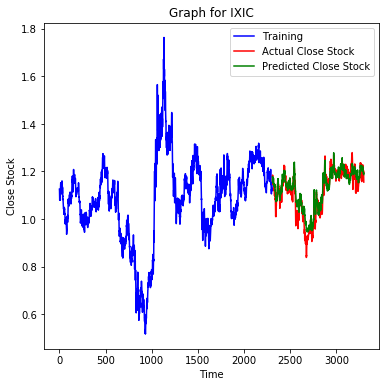

In [185]:
#Use the original data of the first stock
import pandas as pd
import scipy.stats as st
import math
ind =int(0.7*len(y))
dt0=pd.DataFrame(y[:,0])    #first stock
dt=x[:,0:4:,]
dtt=xx[:,0:4:,]
train_x, test_x =dt[:ind,0:4:,], dt[ind:,0:4:,]
train_xx, test_xx =dtt[:ind,0:4:,], dtt[ind:,0:4:,]
train_y, test_y =dt0[:ind], dt0[ind:]
pred_y =model.predict(test_x)
ppy =pred_y[:,0]
#ppy=pd.DataFrame(pred_y[:,0], index=test_y.index)
fc_series =pd.Series(pred_y[:,0], index=test_y.index)
print(test_y.shape)
print(train_y.shape)
# print(fc_.shape)
def conf_int(fc_serie, ci):
#     n=fc_series.count()
    arr=np.array(fc_serie)
    n =len(fc_series)
    #rint(n)
    for i in range(n):
        xbar =np.mean(arr, axis=0)
        
        xstd=np.std(arr, axis=0)
        ts=st.t.ppf((ci +1)/2,n)
        lb =xbar-(ts*(xstd/math.sqrt(n)))
        ub =xbar+(ts*(xstd/math.sqrt(n)))
    return lb, ub
lb, ub =conf_int(ppy,0.95)


#Construct the confidence interval
plt.plot(train_y, 'b')
plt.plot(test_y, 'r')
plt.plot(fc_series, 'g')
#plt.fill_between(fc_series.index, lb,ub, color='k', alpha=0.20)
plt.xlabel('Time')
plt.ylabel('Close Stock')
plt.legend(['Training', 'Actual Close Stock', 'Predicted Close Stock'], loc ='best')
plt.title('Graph for IXIC')
plt.savefig('dnn.png')
# print(lb)

## THE LSTM MODEL

In [139]:
mod =Sequential()
mod.add(LSTM(440,input_shape=[x.shape[1], x.shape[2]]))
mod.add(Dense(y.shape[1]))
mod.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])
# model.summary()
mod.summary()



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 440)               1128160   
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 1764      
Total params: 1,129,924
Trainable params: 1,129,924
Non-trainable params: 0
_________________________________________________________________


In [186]:
hist =mod.fit(x, y, batch_size=64,epochs=100, validation_split=0.3, verbose=0)

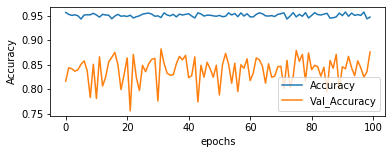

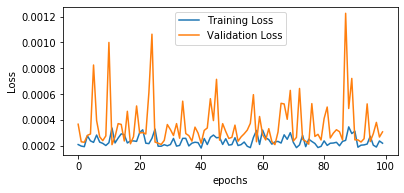

In [187]:
plt.figure(1)
plt.subplot(211)
plt.subplots_adjust(hspace=1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Val_Accuracy'], loc='best')
plt.show()
plt.figure(2)
plt.subplot(212)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='best')
plt.show()


In [188]:
score =mod.evaluate(x, y, verbose=0)
print('Training Loss', score[0])
print('Training  Accuracy', score[1])

Training Loss 0.0002841386229798684
Training  Accuracy 0.9302818775177002


## RMSE for each 4 stocks

In [189]:
### RMSE for each four Stocks
inp = x[-990:]
inpx = xx[-990:]
inpy = yy[-990:]
p = mod.predict(inp)
exp = y[-990:]*inpy
pred=p*inpy
#ixic
e1 =exp[:,0:1]
pr1=pred[:,0:1]
#n225
e2 =exp[:,1:2]
pr2=pred[:,1:2]
#gspc
e3 =exp[:,2:3]
pr3=pred[:,2:3]
#dji
e4 =exp[:,3:4]
pr4=pred[:,3:4]

rmse1 = np.sqrt(mean_squared_error(e1, pr1))
rmse2 = np.sqrt(mean_squared_error(e2, pr2))
rmse3 = np.sqrt(mean_squared_error(e3, pr3))
rmse4 = np.sqrt(mean_squared_error(e4, pr4))
print('RMSE for IXIC using LSTM: %.3f' % rmse1)
print('RMSE for N225 using LSTM: %.3f' % rmse2)
print('RMSE for GSPC using LSTM: %.3f' % rmse3)
print('RMSE for DJI using LSTM: %.3f' % rmse4)

RMSE for IXIC using LSTM: 101.023
RMSE for N225 using LSTM: 427.395
RMSE for GSPC using LSTM: 33.662
RMSE for DJI using LSTM: 306.840


#### Prediction one time step forward for the four stocks

In [190]:
inpx = xx[-1].reshape((1, dat.shape[0], 200))
inpp = x[-1].reshape((1, dat.shape[0], 200))
pp = mod.predict(inpp).reshape(dat.shape[0])
print('recent:     ', inpp[0,:,-1]*inpx[0,:,-1])
print('expected:   ', y[-1]*inpx[0,:,-1])
print('prediction: ', pp*inpx[0,:,-1])

recent:      [ 9065.98242709 24408.45998708  3109.58899845 28319.91095183]
expected:    [ 8940.11775484 24418.0740329   3091.69586105 28159.34566583]
prediction:  [ 8978.7062676  24131.38934011  3098.1700847  27928.02432114]


## RMSE for all four stocks

In [191]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y[-1]*inpx[0,:,-1], pp*inpx[0,:,-1]))
print('RMSE: %.3f' % rmse)

RMSE: 185.222


#### Graphs of prediction for IXIC

(990, 1)
(2309, 1)


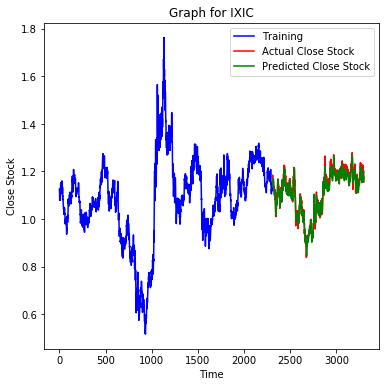

In [192]:
ind =int(0.7*len(y))
dt0=pd.DataFrame(y[:,0])    #first stock
dt=x[:,0:8:,]
train1_x, test1_x =dt[:ind,0:8:,], dt[ind:,0:8:,]
train1_y, test1_y =dt0[:ind], dt0[ind:]
pred1_y =mod.predict(test_x)
ppy =pred1_y[:,0]
#ppy=pd.DataFrame(pred_y[:,0], index=test_y.index)
fc_series1 =pd.Series(pred1_y[:,0], index=test1_y.index)
print(test1_y.shape)
print(train1_y.shape)
# print(fc_.shape)
def conf_int(fc_serie, ci):
#     n=fc_series.count()
    arr=np.array(fc_serie)
    n =len(fc_series)
    #rint(n)
    for i in range(n):
        xbar =np.mean(arr, axis=0)
        
        xstd=np.std(arr, axis=0)
        ts=st.t.ppf((ci +1)/2,n)
        lb =xbar-(ts*(xstd/math.sqrt(n)))
        ub =xbar+(ts*(xstd/math.sqrt(n)))
    return lb, ub
lb, ub =conf_int(ppy,0.95)


#Construct the confidence interval
plt.plot(train1_y, 'b')
plt.plot(test1_y, 'r')
plt.plot(fc_series1, 'g')
#plt.fill_between(fc_series1.index, lb,ub, color='k', alpha=0.20)
plt.xlabel('Time')
plt.ylabel('Close Stock')
plt.legend(['Training', 'Actual Close Stock', 'Predicted Close Stock'], loc ='best')
plt.title('Graph for IXIC')
plt.savefig('lstm.png')